In [ ]:
import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

In [ ]:
def probability_improvement(x, gaussian_process, evaluated_loss, xp=None, greater_is_better=True, n_params=1):
    
    """ 
    Probability improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values of the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)
    
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)
    
    scaling_factor = (-1) ** (not greater_is_better)   

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        probability_improvement = norm.cdf(Z)
        probability_improvement[sigma == 0.0] == 0.0

    return -1 * probability_improvement

def modified_PI(x, gaussian_process, evaluated_loss, xp, greater_is_better=True, n_params=1):
    
    """ 
    Modified Probability improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values of the loss function for the previously
            evaluated hyperparameters.
        xp: array-like, shape = [1, n_hyperparams]
            The sample hyperparameters in previous iterations.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)
    
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
        optimal_index=np.argmax(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)
        optimal_index=np.argmin(evaluated_loss)
    
    #The optimal sample points from previous interations.
    optimal_x=np.reshape(xp[optimal_index],(-1,n_params))
    # X to predict.
    x_to_predict=np.array(x_to_predict)
    optimal_x=np.array(optimal_x)
    X=np.concatenate((optimal_x, x_to_predict))
    
    mu, kappa = gaussian_process.predict(X,return_cov=True)
    sigma=np.sqrt(np.diag(kappa[1:,1:]))
    
    new_sigma=(sigma**2 + kappa[0,0]- 2*kappa[0,1:])
    new_sigma=np.sqrt(new_sigma)
    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor*(mu[1:] - mu[0]) / new_sigma
        probability_improvement = norm.cdf(Z)
        probability_improvement[new_sigma == 0.0] == 0.0

    return -1 * probability_improvement

In [ ]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, xp,  
                               bounds, greater_is_better=True, n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        bounds: array-like, shape = [n_hyperparams, 2]
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):
        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, xp, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, acquisition_func, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        acquisition_func: function.
            The choice of acquisition_function.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        # 这里可以尝试不同kernel
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            ac_fun = acquisition_func
            next_sample = sample_next_hyperparameter(ac_fun, model, yp, xp, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [ ]:
from skopt.benchmarks import branin

def bench(x, noise_level=0.01):
    return (-1) * branin(x) + noise_level * np.random.randn()

In [ ]:
# initial points
x_1 = np.array([[-3.771320643266746,14.9792480506406],
               [-2.6336482349262753,11.251196117461388],
               [-4.49850701230259,10.775203354469152],
               [-1.198062864759624,12.239469287801041],
               [-0.16911083656253556,13.91166018582599]])

# set bouns
bounds = np.array([[-5, 10], [0, 15]])

In [ ]:
# pi + noise_level=0.01
pi_xp1, pi_yp1 = bayesian_optimisation(n_iters=60, 
                                       acquisition_func=probability_improvement,
                                       sample_loss=bench, 
                                       bounds=bounds,
                                       x0=x_1)

In [ ]:
# mpi + noise_level=0.01
mpi_xp1, mpi_yp1 = bayesian_optimisation(n_iters=60, 
                                       acquisition_func=modified_PI,
                                       sample_loss=bench, 
                                       bounds=bounds,
                                       x0=x_1)

In [ ]:
def bench(x, noise_level=0.05):
    return (-1) * branin(x) + noise_level * np.random.randn()

# pi + noise_level=0.05
pi_xp2, pi_yp2 = bayesian_optimisation(n_iters=60, 
                                       acquisition_func=probability_improvement,
                                       sample_loss=bench, 
                                       bounds=bounds,
                                       x0=x_1)

# mpi + noise_level=0.05
mpi_xp2, mpi_yp2 = bayesian_optimisation(n_iters=60, 
                                       acquisition_func=modified_PI,
                                       sample_loss=bench, 
                                       bounds=bounds,
                                       x0=x_1)

In [ ]:
def bench(x, noise_level=0.1):
    return (-1) * branin(x) + noise_level * np.random.randn()

# pi + noise_level=0.1
pi_xp3, pi_yp3 = bayesian_optimisation(n_iters=60, 
                                       acquisition_func=probability_improvement,
                                       sample_loss=bench, 
                                       bounds=bounds,
                                       x0=x_1)

# mpi + noise_level=0.1
mpi_xp3, mpi_yp3 = bayesian_optimisation(n_iters=60, 
                                       acquisition_func=modified_PI,
                                       sample_loss=bench, 
                                       bounds=bounds,
                                       x0=x_1)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00250962]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


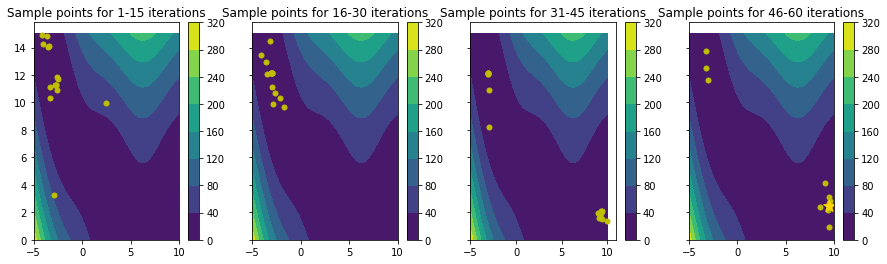

In [ ]:
import matplotlib.pyplot as plt

# noise_level=0.01
## create grid
first_param_grid = np.linspace(-5, 10, 150)
second_param_grid = np.linspace(0, 15, 150)
param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

# compute the objective function
fx = np.array([branin(x_i) for x_i in param_grid])
X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

# create figure
fig = plt.figure(figsize=(15,4))
ax1, ax2, ax3, ax4 = fig.subplots(1, 4, sharey=True)

# rendering
cp1 = ax1.contourf(X, Y, fx.reshape(X.shape))
ax1.scatter(pi_xp1[5:20][:,0], pi_xp1[5:20][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp1, ax=ax1)
ax1.set_title("Sample points for 1-15 iterations")

cp2 = ax2.contourf(X, Y, fx.reshape(X.shape))
ax2.scatter(pi_xp1[20:35][:,0], pi_xp1[20:35][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp2, ax=ax2)
ax2.set_title("Sample points for 16-30 iterations")

cp3 = ax3.contourf(X, Y, fx.reshape(X.shape))
ax3.scatter(pi_xp1[35:50][:,0], pi_xp1[35:50][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp3, ax=ax3)
ax3.set_title("Sample points for 31-45 iterations")

cp4 = ax4.contourf(X, Y, fx.reshape(X.shape))
ax4.scatter(pi_xp1[50:65][:,0], pi_xp1[50:65][:,1], c='y', marker = '.', s=100)
ax4.scatter(pi_xp1[np.argmax(pi_yp1)][0], pi_xp1[np.argmax(pi_yp1)][1], marker='*', c='gold', s=150)
plt.colorbar(cp4, ax=ax4)
ax4.set_title("Sample points for 46-60 iterations")

plt.show()

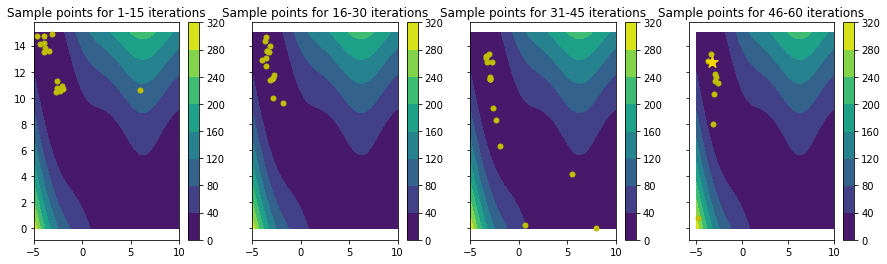

In [ ]:
##### Modified PI ######

# create figure
fig = plt.figure(figsize=(15,4))
ax1, ax2, ax3, ax4 = fig.subplots(1, 4, sharey=True)

# rendering
cp1 = ax1.contourf(X, Y, fx.reshape(X.shape))
ax1.scatter(mpi_xp1[5:20][:,0], mpi_xp1[5:20][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp1, ax=ax1)
ax1.set_title("Sample points for 1-15 iterations")

cp2 = ax2.contourf(X, Y, fx.reshape(X.shape))
ax2.scatter(mpi_xp1[20:35][:,0], mpi_xp1[20:35][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp2, ax=ax2)
ax2.set_title("Sample points for 16-30 iterations")

cp3 = ax3.contourf(X, Y, fx.reshape(X.shape))
ax3.scatter(mpi_xp1[35:50][:,0], mpi_xp1[35:50][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp3, ax=ax3)
ax3.set_title("Sample points for 31-45 iterations")

cp4 = ax4.contourf(X, Y, fx.reshape(X.shape))
ax4.scatter(mpi_xp1[50:65][:,0], mpi_xp1[50:65][:,1], c='y', marker = '.', s=100)
ax4.scatter(mpi_xp1[np.argmax(mpi_yp1)][0], mpi_xp1[np.argmax(mpi_yp1)][1], marker='*', c='gold', s=150)
plt.colorbar(cp4, ax=ax4)
ax4.set_title("Sample points for 46-60 iterations")

plt.show()

In [ ]:
# pi 0.01
sample_index = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 61, 62, 63, 64, 65])
plot_index = sample_index - 5
sample_pi_x1 = []
sample_pi_y1 = []
for i in sample_index:
    sample_pi_x1.append(pi_xp1[np.argmax(pi_yp1[:i])])
    sample_pi_y1.append(max(pi_yp1[:i]))
    
plot_pi_x1 = np.array(sample_pi_x1)
plot_pi_y1 = np.array(sample_pi_y1)

In [ ]:
# pi 0.05
sample_pi_x2 = []
sample_pi_y2 = []
for i in sample_index:
    sample_pi_x2.append(pi_xp2[np.argmax(pi_yp2[:i])])
    sample_pi_y2.append(max(pi_yp2[:i]))
    
plot_pi_x2 = np.array(sample_pi_x2)
plot_pi_y2 = np.array(sample_pi_y2)

In [ ]:
# pi 0.1
sample_pi_x3 = []
sample_pi_y3 = []
for i in sample_index:
    sample_pi_x3.append(pi_xp3[np.argmax(pi_yp3[:i])])
    sample_pi_y3.append(max(pi_yp3[:i]))
    
plot_pi_x3 = np.array(sample_pi_x3)
plot_pi_y3 = np.array(sample_pi_y3)

In [ ]:
# mpi 0.01
sample_index = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 61, 62, 63, 64, 65])
plot_index = sample_index - 5
sample_mpi_x1 = []
sample_mpi_y1 = []
for i in sample_index:
    sample_mpi_x1.append(mpi_xp1[np.argmax(mpi_yp1[:i])])
    sample_mpi_y1.append(max(mpi_yp1[:i]))
    
plot_mpi_x1 = np.array(sample_mpi_x1)
plot_mpi_y1 = np.array(sample_mpi_y1)

In [ ]:
# mpi 0.05
sample_mpi_x2 = []
sample_mpi_y2 = []
for i in sample_index:
    sample_mpi_x2.append(mpi_xp2[np.argmax(mpi_yp2[:i])])
    sample_mpi_y2.append(max(mpi_yp2[:i]))
    
plot_mpi_x2 = np.array(sample_mpi_x2)
plot_mpi_y2 = np.array(sample_mpi_y2)

In [ ]:
# mpi 0.1
sample_mpi_x3 = []
sample_mpi_y3 = []
for i in sample_index:
    sample_mpi_x3.append(mpi_xp3[np.argmax(mpi_yp3[:i])])
    sample_mpi_y3.append(max(mpi_yp3[:i]))
    
plot_mpi_x3 = np.array(sample_mpi_x3)
plot_mpi_y3 = np.array(sample_mpi_y3)